In [1]:
from attentif.masked_lm import MaskedLM, MaskedLMConfig
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from pathlib import Path

In [2]:
# Tokenizerの準備
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# データセット読み込み
dataset = load_dataset("allenai/c4", "realnewslike", split="train[:200000]")
print(f"Dataset loaded: {len(dataset)} samples")

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

Dataset loaded: 200000 samples


In [3]:
# トークナイズ
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=128,  # 短めにして学習を速く
        return_special_tokens_mask=True,
    )

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=dataset.column_names,
)

print(f"Dataset tokenized: {len(tokenized_dataset)} samples")

Dataset tokenized: 200000 samples


In [4]:
config = MaskedLMConfig(
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=12,
    vocab_size=tokenizer.vocab_size,
    pad_token_id=tokenizer.pad_token_id,
)
model = MaskedLM(config)

assert(config.vocab_size == tokenizer.vocab_size)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 108,527,418


In [5]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
)

print("DataCollator configured")

DataCollator configured


In [6]:
# ハイパーパラメータ
learning_rate = 1e-4
weight_decay = 0.01
warmup_ratio = 0.06
batch_size = 32
num_epochs = 3

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# モデルをデバイスに移動
model = model.to(device)

# DataLoaderの作成
train_dataloader = DataLoader(
    tokenized_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)

# オプティマイザの設定
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
)

# Warmup schedulerの設定
total_steps = len(train_dataloader) * num_epochs
warmup_steps = int(total_steps * warmup_ratio)

def get_lr_scheduler(optimizer, warmup_steps, total_steps):
    """Linear warmup followed by linear decay"""
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        return max(0.0, float(total_steps - current_step) / float(max(1, total_steps - warmup_steps)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_lr_scheduler(optimizer, warmup_steps, total_steps)

print(f"Total steps: {total_steps}, Warmup steps: {warmup_steps}")
print("Training setup complete")

Using device: mps
Total steps: 18750, Warmup steps: 1125
Training setup complete


In [7]:
# 訓練ループ
model.train()
global_step = 0
loss_history = []  # lossを記録するリスト

# 損失関数の定義
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"{'='*60}")
    
    epoch_loss = 0.0
    
    for step, batch in enumerate(train_dataloader):
        # バッチをデバイスに移動
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        # 順伝播
        logits = model(input_ids, attention_mask)
        
        # 損失計算
        # logits: (batch_size, seq_len, vocab_size)
        # labels: (batch_size, seq_len) - マスクされていない位置は-100
        loss = loss_fn(
            logits.view(-1, logits.shape[-1]),  # (batch_size * seq_len, vocab_size)
            labels.view(-1)  # (batch_size * seq_len,)
        )
        
        # 逆伝播
        optimizer.zero_grad()
        loss.backward()
        
        # 勾配クリッピング（オプション、オーバーフロー防止）
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item()
        global_step += 1
        
        # lossを記録
        loss_history.append(loss.item())
        
        # ステップごとにlossを出力
        if (step + 1) % 100 == 0 or step == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Step {global_step:5d} | Loss: {loss.item():.4f} | LR: {current_lr:.6f}")
    
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"\nEpoch {epoch + 1} Average Loss: {avg_epoch_loss:.4f}")

print("\n" + "="*60)
print("Training completed!")
print("="*60)


Epoch 1/3
Step     1 | Loss: 10.5270 | LR: 0.000000
Step   100 | Loss: 8.9253 | LR: 0.000009
Step   200 | Loss: 8.3476 | LR: 0.000018
Step   300 | Loss: 7.5451 | LR: 0.000027
Step   400 | Loss: 7.3225 | LR: 0.000036
Step   500 | Loss: 7.3521 | LR: 0.000044
Step   600 | Loss: 7.4653 | LR: 0.000053
Step   700 | Loss: 7.3961 | LR: 0.000062
Step   800 | Loss: 7.2377 | LR: 0.000071
Step   900 | Loss: 7.3656 | LR: 0.000080
Step  1000 | Loss: 7.2244 | LR: 0.000089
Step  1100 | Loss: 7.3558 | LR: 0.000098
Step  1200 | Loss: 7.1261 | LR: 0.000100
Step  1300 | Loss: 7.4852 | LR: 0.000099
Step  1400 | Loss: 7.2638 | LR: 0.000098
Step  1500 | Loss: 7.3354 | LR: 0.000098
Step  1600 | Loss: 7.0452 | LR: 0.000097
Step  1700 | Loss: 7.1293 | LR: 0.000097
Step  1800 | Loss: 7.0739 | LR: 0.000096
Step  1900 | Loss: 7.1973 | LR: 0.000096
Step  2000 | Loss: 6.9321 | LR: 0.000095
Step  2100 | Loss: 7.1912 | LR: 0.000094
Step  2200 | Loss: 6.7481 | LR: 0.000094
Step  2300 | Loss: 6.9010 | LR: 0.000093
Step

In [9]:
# モデルの保存
output_dir = Path("../output/masked_lm")
output_dir.mkdir(parents=True, exist_ok=True)

# モデルのstate_dictを保存
model_path = output_dir / "model.pt"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# 設定も保存しておく
config_path = output_dir / "config.txt"
with open(config_path, "w") as f:
    f.write(f"hidden_size={config.hidden_size}\n")
    f.write(f"num_attention_heads={config.num_attention_heads}\n")
    f.write(f"num_hidden_layers={config.num_hidden_layers}\n")
    f.write(f"vocab_size={config.vocab_size}\n")
    f.write(f"pad_token_id={config.pad_token_id}\n")
    f.write(f"\nTraining hyperparameters:\n")
    f.write(f"learning_rate={learning_rate}\n")
    f.write(f"weight_decay={weight_decay}\n")
    f.write(f"warmup_ratio={warmup_ratio}\n")
    f.write(f"batch_size={batch_size}\n")
    f.write(f"num_epochs={num_epochs}\n")
print(f"Config saved to {config_path}")

print("\nAll files saved successfully!")

Model saved to ../output/masked_lm/model.pt
Config saved to ../output/masked_lm/config.txt

All files saved successfully!


Loss plot saved to ../output/masked_lm/training_loss.png


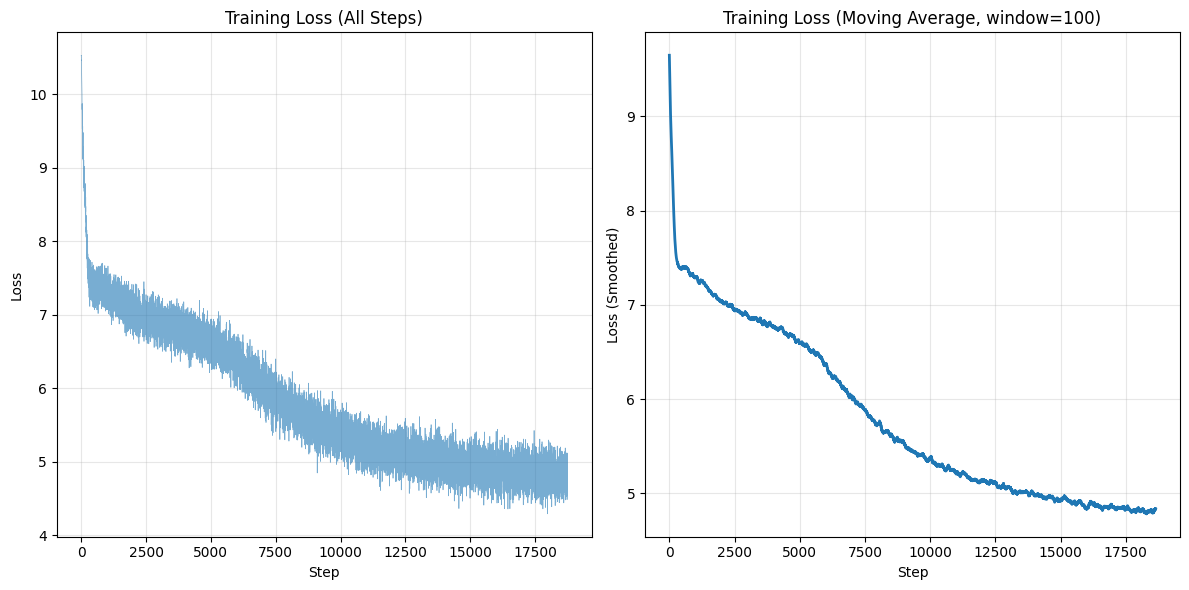

In [10]:
# Lossの可視化
plt.figure(figsize=(12, 6))

# 全ステップのlossをプロット
plt.subplot(1, 2, 1)
plt.plot(loss_history, alpha=0.6, linewidth=0.5)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss (All Steps)")
plt.grid(True, alpha=0.3)

# 移動平均でスムージング
window_size = 100
if len(loss_history) >= window_size:
    smoothed_loss = []
    for i in range(len(loss_history) - window_size + 1):
        smoothed_loss.append(sum(loss_history[i:i+window_size]) / window_size)
    
    plt.subplot(1, 2, 2)
    plt.plot(smoothed_loss, linewidth=2)
    plt.xlabel("Step")
    plt.ylabel("Loss (Smoothed)")
    plt.title(f"Training Loss (Moving Average, window={window_size})")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / "training_loss.png", dpi=150, bbox_inches="tight")
print(f"Loss plot saved to {output_dir / 'training_loss.png'}")
plt.show()